In [13]:
import os
import numpy as np
import pandas as pd
import cv2
from ultralytics import YOLO
from tqdm import tqdm  # nice progress bars
import time
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import seaborn as sns

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
# Traning YOLO Detector on Dataset
detector = YOLO("runs/detect/detector_opt/weights/last.pt")
detector.train(
    data="dataset/data.yaml",
    epochs=15,         # enough 
    imgsz=320,         # smaller, much faster
    batch=2,           # safe for 8GB VRAM
    device=0,          # use GPU
    workers=1,         # smooth dataloading
    amp=True,          # reduces VRAM by ~30%
    val=False,         # saves 35% time
    name="detector_opt",
    resume=True
)

Ultralytics 8.3.228  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\detector_opt\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detector_opt, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002034CBE06D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [6]:
# crops the bounding box for each detected pest and saves into new dataset folder
detector_opt = YOLO("yolo_transfer_model3/weights/best.pt") # only for class names 
data_root = "dataset"
output_root = "cropped_dataset" # new classsification dataset
splits = ["train", "valid", "test"]
# create output folders with class names
for split in splits:
    for cls_name in detector_opt.names.values():
        os.makedirs(os.path.join(output_root, split, cls_name), exist_ok=True)

# Function to crop images using truth labels from OG dataset, not YOLO predictions -> avoiding error propagation
def crop_using_labels(img_path, label_path, save_dir):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()
        
    # process each bounding box
    for i, line in enumerate(lines):
        cls_id, xc, yc, bw, bh = map(float, line.split())

        # convert to pixel coords
        x1 = max(0, int((xc - bw/2) * w))
        y1 = max(0, int((yc - bh/2) * h))
        x2 = min(w, int((xc + bw/2) * w))
        y2 = min(h, int((yc + bh/2) * h))
        
        # Crop the region from the image
        crop_img = img[y1:y2, x1:x2]
        # Skip empty or invalid crops
        if crop_img.size == 0:
            continue     
            
        # Map class ID → human-readable class name
        cls_name = detector_opt.names[int(cls_id)]
        base = os.path.basename(img_path).replace(".jpg", f"_{i}.jpg")
        save_path = os.path.join(save_dir, cls_name, base)
        cv2.imwrite(save_path, crop_img)

# process all dataset splits
for split in splits:
    img_dir = os.path.join(data_root, split, "images")
    label_dir = os.path.join(data_root, split, "labels")
    save_dir = os.path.join(output_root, split)

    images = [f for f in os.listdir(img_dir) if f.endswith((".jpg",".png",".jpeg"))]

    print(f"\nProcessing {split} split ({len(images)} images)...")
    for f in tqdm(images):
        img_path = os.path.join(img_dir, f)
        label_path = os.path.join(label_dir, f.replace(".jpg",".txt").replace(".png",".txt"))
        crop_using_labels(img_path, label_path, save_dir)
print("\nFinished cropping dataset successfully.")


Processing train split (11502 images)...


100%|██████████| 11502/11502 [02:18<00:00, 82.82it/s] 



Processing valid split (1095 images)...


100%|██████████| 1095/1095 [00:04<00:00, 222.52it/s]



Processing test split (546 images)...


100%|██████████| 546/546 [00:02<00:00, 229.71it/s]


Finished cropping dataset successfully.


In [7]:
# Now training ResNet50 model using transfer learning from cropped classification dataset
res_data_root = output_root     
batch_size = 32               
num_workers = 2               
num_epochs = 15               # Enough for transfer learning
learning_rate = 1e-4
img_size = 224                # ResNet50 requires 224x224 input

# Load pretrained weights
weights = ResNet50_Weights.IMAGENET1K_V2

# ImageNet normalisation stats from pretrained weights
imagenet_mean = weights.transforms().mean
imagenet_std = weights.transforms().std

# training transfomrations
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
# validation + test transformation
test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Create PyTorch datasets and dataloaders using folder structure
train_ds = datasets.ImageFolder(os.path.join(res_data_root, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(res_data_root, "valid"), transform=test_tf)
test_ds  = datasets.ImageFolder(os.path.join(res_data_root, "test"),  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = train_ds.classes
num_classes = len(classes)
print("Classes found:", classes)

Classes found: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [10]:
resnet_model = models.resnet50(weights=weights)

# freeze feature extractor
for param in resnet_model.parameters():
    param.requires_grad = False
    
# replace final layer with dataset classes
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(resnet_model.fc.parameters(), lr=learning_rate)

# training loop
for epoch in range(num_epochs):
    resnet_model.train()
    train_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimiser.zero_grad() # clears gradients from previous iteration
        outputs = resnet_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        train_loss += loss.item()

    # Validation
    resnet_model.eval()
    val_loss = 0
    val_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = resnet_model(imgs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss:   {val_loss/len(val_loader):.4f}")
    print(f"Val Acc:    {100*val_correct/total:.2f}%\n")

torch.save(resnet_model.state_dict(), "resnet50_transferlearn.pth")

Epoch 1/15: 100%|██████████| 478/478 [01:36<00:00,  4.95it/s]


Epoch 1/15
Train Loss: 1.9477
Val Loss:   1.6144
Val Acc:    69.05%



Epoch 2/15: 100%|██████████| 478/478 [00:44<00:00, 10.85it/s]


Epoch 2/15
Train Loss: 1.3447
Val Loss:   1.2230
Val Acc:    74.20%



Epoch 3/15: 100%|██████████| 478/478 [00:43<00:00, 10.93it/s]


Epoch 3/15
Train Loss: 1.0547
Val Loss:   0.9966
Val Acc:    78.30%



Epoch 4/15: 100%|██████████| 478/478 [00:45<00:00, 10.53it/s]


Epoch 4/15
Train Loss: 0.8985
Val Loss:   0.8942
Val Acc:    78.67%



Epoch 5/15: 100%|██████████| 478/478 [00:44<00:00, 10.84it/s]


Epoch 5/15
Train Loss: 0.7985
Val Loss:   0.8104
Val Acc:    80.16%



Epoch 6/15: 100%|██████████| 478/478 [00:44<00:00, 10.86it/s]


Epoch 6/15
Train Loss: 0.7274
Val Loss:   0.7586
Val Acc:    80.54%



Epoch 7/15: 100%|██████████| 478/478 [00:43<00:00, 10.87it/s]


Epoch 7/15
Train Loss: 0.6720
Val Loss:   0.7098
Val Acc:    80.69%



Epoch 8/15: 100%|██████████| 478/478 [00:43<00:00, 11.08it/s]


Epoch 8/15
Train Loss: 0.6317
Val Loss:   0.6770
Val Acc:    81.51%



Epoch 9/15: 100%|██████████| 478/478 [00:42<00:00, 11.17it/s]


Epoch 9/15
Train Loss: 0.5975
Val Loss:   0.6485
Val Acc:    81.51%



Epoch 10/15: 100%|██████████| 478/478 [00:43<00:00, 11.01it/s]


Epoch 10/15
Train Loss: 0.5663
Val Loss:   0.6392
Val Acc:    81.88%



Epoch 11/15: 100%|██████████| 478/478 [00:43<00:00, 11.00it/s]


Epoch 11/15
Train Loss: 0.5448
Val Loss:   0.6084
Val Acc:    82.48%



Epoch 12/15: 100%|██████████| 478/478 [00:42<00:00, 11.19it/s]


Epoch 12/15
Train Loss: 0.5230
Val Loss:   0.5996
Val Acc:    83.30%



Epoch 13/15: 100%|██████████| 478/478 [00:43<00:00, 10.90it/s]


Epoch 13/15
Train Loss: 0.5087
Val Loss:   0.5857
Val Acc:    82.40%



Epoch 14/15: 100%|██████████| 478/478 [00:43<00:00, 10.96it/s]


Epoch 14/15
Train Loss: 0.4877
Val Loss:   0.5857
Val Acc:    82.70%



Epoch 15/15: 100%|██████████| 478/478 [00:42<00:00, 11.31it/s]


Epoch 15/15
Train Loss: 0.4775
Val Loss:   0.5652
Val Acc:    83.22%




===================== YOLO Detection Performance =====================
Ultralytics 8.3.228  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 258.879.3 MB/s, size: 45.1 KB)
val: Scanning C:\Users\Arkansh\OneDrive - UNSW\25T3\COMP9517\Project\dataset\test\labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 5.9it/s 5.9s0.1s
                   all        546        689       0.83      0.716      0.769      0.471
                  Ants         54         87      0.859      0.698      0.786      0.337
                  Bees         40         44      0.812      0.886      0.889      0.457
               Beetles         41         44      0.701      0.693      0.723      0.404
          Cater

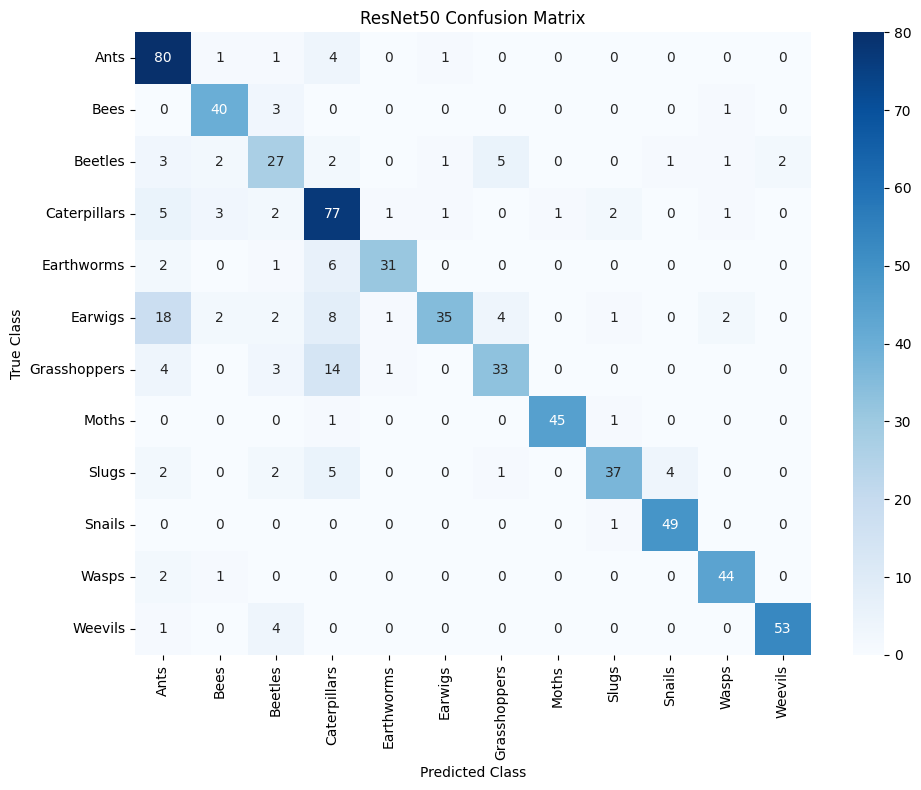

In [16]:
# Provide statistics and results 

# YOLO detection performance
print("\n===================== YOLO Detection Performance =====================")
detector_stat = YOLO("yolo_transfer_model3/weights/best.pt")
metrics = detector_stat.val(data="dataset/data.yaml", split="test", device=0)

mAP50      = metrics.box.map50     # mAP@0.50
mAP5095    = metrics.box.map       # mAP@[0.50:0.95]
precision  = metrics.box.mp        # mean precision
recall     = metrics.box.mr        # mean recall
print(f"mAP@50:         {mAP50:.4f}")
print(f"mAP@50–95:      {mAP5095:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print("===============================================================================\n")
print("===================== ResNet50 Classification Performance =====================")
# Resnet 50 Classification Performance
y_true = []
y_pred = []
y_prob = []  

resnet_model.eval()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        outputs = resnet_model(imgs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()

        preds = np.argmax(probs, axis=1) 

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)     # n_samples × n_classes

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

# convert true labels to one-hot
y_true_oh = np.zeros_like(y_prob)
for i, label in enumerate(y_true):
    y_true_oh[i][label] = 1

auc = roc_auc_score(y_true_oh, y_prob, average="weighted", multi_class="ovr")
print(f"AUC      : {auc:.4f}")
print("===============================================================================\n")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()